Сие уравнение, предложенное Дж. Хиггинсом, описывает простейшую модель гликолиза
\begin{cases}
\dot{x} = 1 - xy & \\
\dot{y} = \alpha y \Big( x - \frac{1 + \beta}{ y + \beta} \Big)
\end{cases}

In [1]:
import numpy as np
y1_init = 1.
y2_init = 0.001
beta = 4.5 #10
alpha = 2.5 # 100, 200, 400, 1000


In [2]:
def glicole(t, u, jac=False):    
    x, y = u
    if jac:
        return np.array([[-y, -x], [alpha * y, alpha * x - alpha * (1 + beta) * beta / ((y + beta)**2)]])
    return np.array([1. - x * y,
                    alpha * y * (x - (1. + beta) / (y + beta))])
glicole_init = np.array([1., 0.001])
glicole_tmax = 120

Попробуем решить задачу методами Рунге-Кутты 1го, 2го и 4го порядков со следующими таблицами Бутчера: 
$$RK4$$
\begin{array}
{c|cccc}
0\\
\frac{1}{2} & \frac{1}{2}\\
\frac{1}{2} &0 &\frac{1}{2} \\
1& 0& 0& 1\\
\hline
& \frac{1}{6} &\frac{1}{3} &\frac{1}{3} &\frac{1}{6} 
\end{array}



$$MidPoint$$
\begin{array}
{c|cc}
0\\
\frac{1}{2} & \frac{1}{2}\\
\hline
& 0 & 1
\end{array}


$$Euler$$
\begin{array}
{c|c}
0\\
\hline
& 1 
\end{array}

In [3]:
def euler(f, tau, t, u):
    k1 = f(t, u)
    return u + tau * k1
euler.order = 1; euler.name = 'Явный метод Эйлера'

def midpoint(f, tau, t, u):
    k1 = f(t, u)
    k2 = f(t + tau/2, u + tau/2*k1)
    return u + tau * k2
midpoint.order = 2; midpoint.name = 'Явный метод средней точки'

def rk4(f, tau, t, u):
    k1 = f(t, u)
    k2 = f(t + tau/2, u + tau/2*k1)
    k3 = f(t + tau/2, u + tau/2*k2)
    k4 = f(t + tau  , u + tau  *k3)
    return u + tau * (k1 + 2*k2 + 2*k3 + k4) / 6
rk4.order = 4; rk4.name = 'Классический метод РК 4 порядка'

In [4]:
def fixed_stepsize(f, y0, tmax, method, tau=0.1):
    t = 0; u = y0
    T = [0]; Y = [y0]; Y_ = [f(t, y0)]
    name = method.name
    while t < tmax:
        # Если последний шаг выхдит за tmax - уменьшаем tau
        if t + tau > tmax: tau = tmax - t
        u = method(f, tau, t, u)
        t += tau;
        T.append(t)
        Y.append(u)
        Y_.append(f(t, u))
    print('%s, всего шагов: %d'%(name, len(T)-1))
    return np.array(T), np.array(Y), np.array(Y_)

In [15]:
def adaptive_stepsize(f, y0, tmax, method, tol, tau=0.1):
    t = 0; u = y0
    T = [0]; Y = [y0]; Y_ = [f(t, y0)]
    p = method.order; name = method.name
    failed = 0 # Число неудачных шагов
    it = 0
    print_freq = 10
    while t < tmax:
        #print t
        it += 1
        if t + tau > tmax: tau = tmax - t
        u1 = method(f, tau, t, u)                 # Целый шаг
        u2 = method(f, tau/2, t, u)        
        u2 = method(f, tau/2, t+tau/2, u2)     # Два полушага
        err = np.abs(np.linalg.norm(u1-u2)/(1.-2.**(-p))) # Правило Рунге
        fac = (tol/(err))**(1. / (p+1.))       # Подстраиваем tau
        #fac1= (tol/err_prev)**(-0.08)
        taunew = tau * min(1.1, max(0.8, 0.8 * fac))
        #taunew = tau * fac * fac1
        if err < tol:            # Ошибка мала, принимаем шаг
            t += tau; u = u1            
            T.append(t); Y.append(u); Y_.append(f(t, u))
        else: # Если ошибка велика, повторяем шаг с новым tau
            failed += 1
        #if (taunew < 1e-3 and taunew > 0):
        tau = taunew
        
        if it % print_freq == 0:
            print 'it = ', it
            print '|u1 - u2|: \n', np.linalg.norm(u1 - u2)
            print 'err = ', err
            print 'fac = ', fac
            print 'taunew = ', tau
            print 'curr t = ', t
        
    print('%s, всего шагов: %d, отброшено: %d'%(name, len(T)-1, failed))
    return np.array(T), np.array(Y), np.array(Y_)

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import cProfile

# Явный метод эйлера

In [17]:
T, Y, Y_ = adaptive_stepsize(glicole, glicole_init, glicole_tmax, euler, 1e-3, 1e-4)
%time

it =  10
|u1 - u2|: 
3.93970525326e-11
err =  7.87941050652e-11
fac =  3562.48575456
taunew =  0.00025937424601
curr t =  0.0015937424601
it =  20
|u1 - u2|: 
2.63639023147e-10
err =  5.27278046295e-10
fac =  1377.14653988
taunew =  0.000672749994933
curr t =  0.00572749994933
it =  30
|u1 - u2|: 
1.75018675993e-09
err =  3.50037351986e-09
fac =  534.493963999
taunew =  0.00174494022689
curr t =  0.0164494022689
it =  40
|u1 - u2|: 
1.14125337185e-08
err =  2.28250674371e-08
fac =  209.311921864
taunew =  0.00452592555682
curr t =  0.0442592555682
it =  50
|u1 - u2|: 
7.2509427131e-08
err =  1.45018854262e-07
fac =  83.0400812036
taunew =  0.011739085288
curr t =  0.11639085288
it =  60
|u1 - u2|: 
4.99895520491e-07
err =  9.99791040982e-07
fac =  31.6260810517
taunew =  0.0304481639541
curr t =  0.303481639541
it =  70
|u1 - u2|: 
8.25033385457e-06
err =  1.65006677091e-05
fac =  7.78483192796
taunew =  0.0789746956799
curr t =  0.788746956799
it =  80
|u1 - u2|: 
0.000506449641486
er

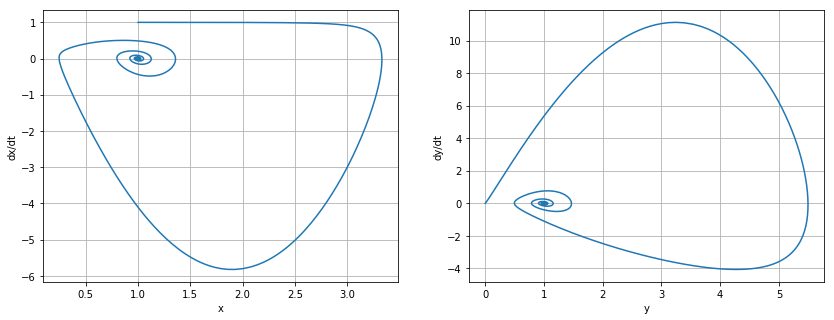

In [12]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(Y[:,0], Y_[:, 0], '-')
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.grid(); 
plt.subplot(1,2,2); plt.plot(Y[:,1], Y_[:, 1], '-')
plt.xlabel('y')
plt.ylabel('dy/dt')
plt.grid(); plt.show()

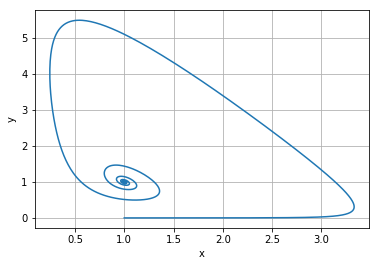

In [13]:
plt.figure() 
plt.subplot(111); plt.plot(Y[:,0], Y[:, 1], '-')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(); plt.show()

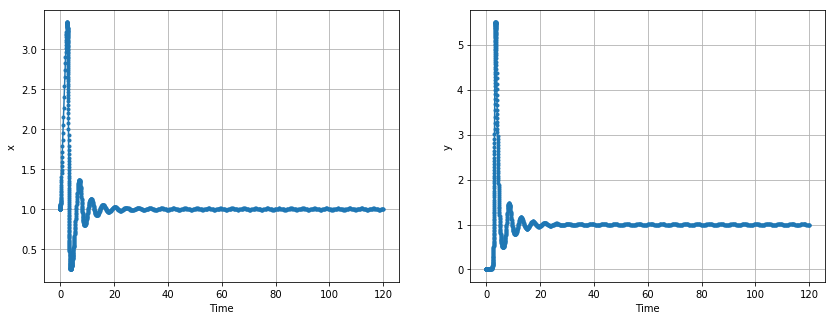

In [14]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(T, Y[:, 0], '.-')
plt.xlabel('Time')
plt.ylabel('x')
plt.grid()
plt.subplot(1,2,2); plt.plot(T, Y[:, 1], '.-')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(); plt.show()

NameError: name 'Y' is not defined

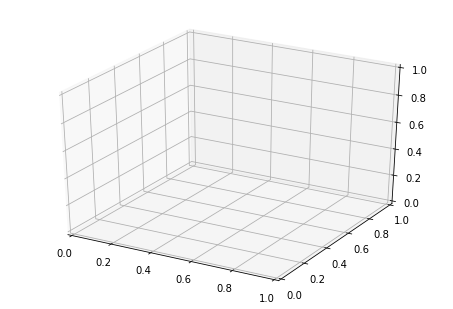

In [2]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

x = Y[:,1]
y = Y_[:,1]
z = T

ax.plot(x, y, z, zdir='z', label='zs=0, zdir=z')
plt.xlabel('y')
plt.ylabel('dy/dt')
plt.show()



In [59]:
def newton(F, dFdx, x0):
    x = x0.copy()
    for it in range(50):
        dx = np.linalg.solve(dFdx(x), F(x))
        x -= dx
        if np.linalg.norm(dx) < 1e-12:
            return x
    #print ('max iter num broken')
    return x




$$Lobatto$$
\begin{array}
{c|cc}
0& 0& 0\\
1 & 1/2& 1/2 \\
\hline
& 1/2 & 1/2
\end{array}


$$Euler$$
\begin{array}
{c|c}
1& 1 \\
\hline
& 1/2
\end{array}

In [60]:
def imeuler(f, h, t, u):
    E = np.eye(len(u))
    k1 = newton(
        lambda k: k - f(t+h, u+h*k), # Уравнение k-f(t+h,u+h*k) = 0
        lambda k: E - h*f(t+h, u+h*k, jac=True), # Производная по k
        f(t, u)) # Начальное приближение
    return u + h*k1/2.
imeuler.order=1; imeuler.name='Неявный Эйлер'

def imlobatto(f, h, t, u):
    E = np.eye(len(u))
    """
    k1 = newton(
        lambda k: k - f(t, u), # Уравнение k-f(t,u) = 0
        lambda k: E - h*f(t, u, jac=True), # Производная по k
        f(t, u)) # Начальное приближение
    """
    k1 = f(t, u)
    k2 = newton(
        lambda k: k - f(t+h, u-h/2.*k1+3.*h/4.*k), # Уравнение k-f(t+h/2,u+h/2*k) = 0
        lambda k: E - (h/2.)*f(t+h, u+h/2.*k1+h/2.*k, jac=True), # Производная по k
        f(t, u)) # Начальное приближение
    
    return u + h*((1./2.)*k1 + k2/2.)
imlobatto.order=2; imlobatto.name='Метод Лобатто'

# Неявный эйлер

In [27]:
T, Y, Y_ = adaptive_stepsize(glicole, glicole_init, glicole_tmax, imeuler, 1e-3, 1e-4)
%time

it =  250
|u1 - u2|: 
2.24247339357e-10
err =  4.48494678714e-10
fac =  1493.21159181
taunew =  0.000984973267581
curr t =  0.231453691149
it =  500
|u1 - u2|: 
1.84756338565e-10
err =  3.69512677131e-10
fac =  1645.07358403
taunew =  0.000984973267581
curr t =  0.477697008044
it =  750
|u1 - u2|: 
1.53235771589e-10
err =  3.06471543179e-10
fac =  1806.36255691
taunew =  0.000984973267581
curr t =  0.723940324939
it =  1000
|u1 - u2|: 
1.27874615066e-10
err =  2.55749230131e-10
fac =  1977.39227178
taunew =  0.000984973267581
curr t =  0.970183641835
it =  1250
|u1 - u2|: 
1.07323454668e-10
err =  2.14646909337e-10
fac =  2158.42856671
taunew =  0.000984973267581
curr t =  1.21642695873
it =  1500
|u1 - u2|: 
9.05950162632e-11
err =  1.81190032526e-10
fac =  2349.26954403
taunew =  0.000984973267581
curr t =  1.46267027563
it =  1750
|u1 - u2|: 
7.6997707806e-11
err =  1.53995415612e-10
fac =  2548.27388694
taunew =  0.000984973267581
curr t =  1.70891359252
it =  2000
|u1 - u2|: 
6.60

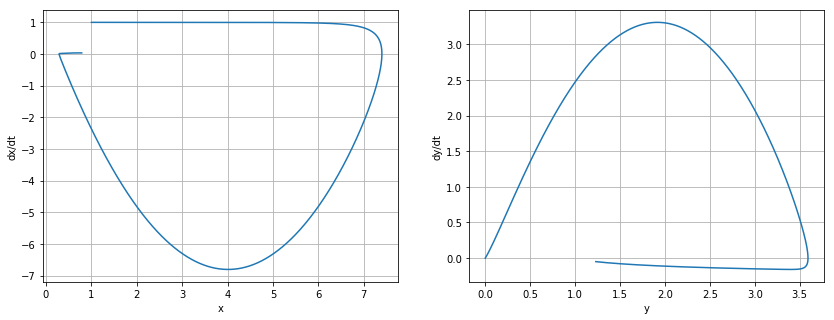

In [28]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(Y[:,0], Y_[:, 0], '-')
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.grid(); 
plt.subplot(1,2,2); plt.plot(Y[:,1], Y_[:, 1], '-')
plt.xlabel('y')
plt.ylabel('dy/dt')
plt.grid(); plt.show()

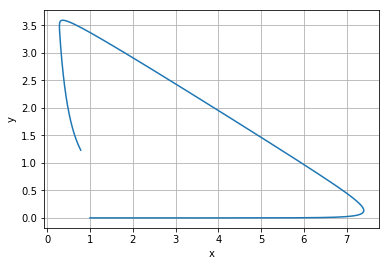

In [29]:
plt.figure() 
plt.subplot(111); plt.plot(Y[:,0], Y[:, 1], '-')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(); plt.show()

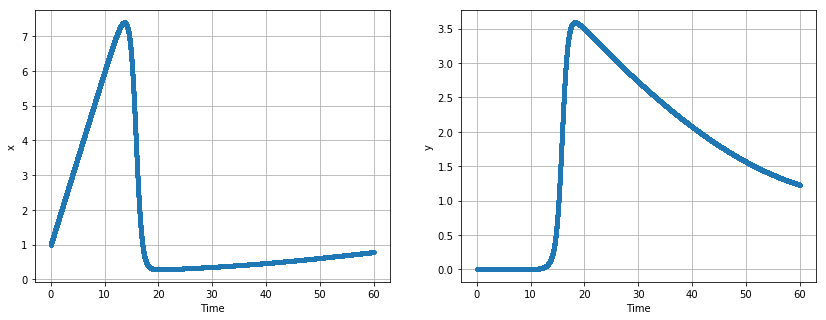

In [30]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(T, Y[:, 0], '.-')
plt.xlabel('Time')
plt.ylabel('x')
plt.grid()
plt.subplot(1,2,2); plt.plot(T, Y[:, 1], '.-')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(); plt.show()

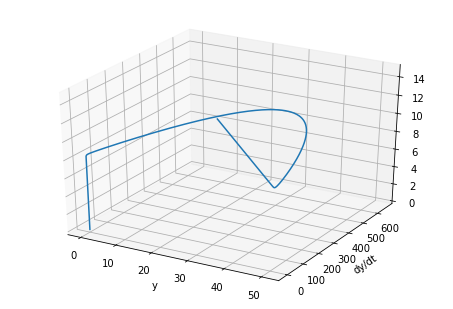

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

x = Y[:,1]
y = Y_[:,1]
z = T

ax.plot(x, y, z, zdir='z', label='zs=0, zdir=z')
plt.xlabel('y')
plt.ylabel('dy/dt')
plt.show()

# Явная средняя точка

In [36]:
T, Y, Y_ = adaptive_stepsize(glicole, glicole_init, glicole_tmax, midpoint, 1e-3, 1e-4)

it =  250
|u1 - u2|: 
8.67138599174e-08
err =  1.1561847989e-07
fac =  20.5269416737
taunew =  0.000984973267581
curr t =  0.231453691149
it =  500
|u1 - u2|: 
0.000358366144216
err =  0.000477821525621
fac =  1.27912041319
taunew =  0.000171456090981
curr t =  0.338726771686
it =  750
|u1 - u2|: 
5.32168038358e-16
err =  7.09557384477e-16
fac =  11211.6833946
taunew =  0.000973667365988
curr t =  0.539747397216
it =  1000
|u1 - u2|: 
5.55111512313e-17
err =  7.40148683083e-17
fac =  23817.3630344
taunew =  0.000973667365988
curr t =  0.783164238713
it =  1250
|u1 - u2|: 
1.11022302463e-16
err =  1.48029736617e-16
fac =  18903.8535679
taunew =  0.000973667365988
curr t =  1.02658108021
it =  1500
|u1 - u2|: 
1.11022302463e-16
err =  1.48029736617e-16
fac =  18903.8535679
taunew =  0.000973667365988
curr t =  1.26999792171
it =  1750
|u1 - u2|: 
2.22044604925e-16
err =  2.96059473233e-16
fac =  15003.99852
taunew =  0.000973667365988
curr t =  1.5134147632
it =  2000
|u1 - u2|: 
2.22044

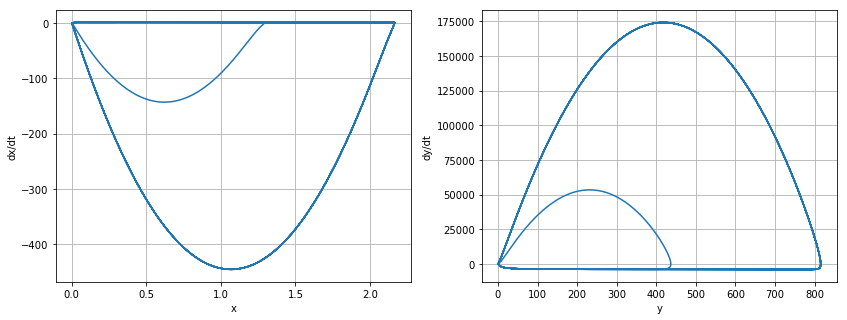

In [37]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(Y[:,0], Y_[:, 0], '-')
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.grid(); 
plt.subplot(1,2,2); plt.plot(Y[:,1], Y_[:, 1], '-')
plt.xlabel('y')
plt.ylabel('dy/dt')
plt.grid(); plt.show()

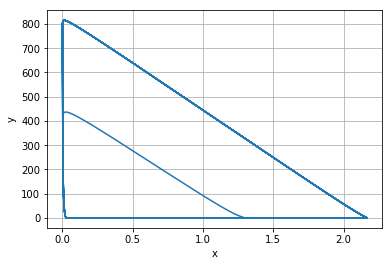

In [38]:
plt.figure() 
plt.subplot(111); plt.plot(Y[:,0], Y[:, 1], '-')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(); plt.show()

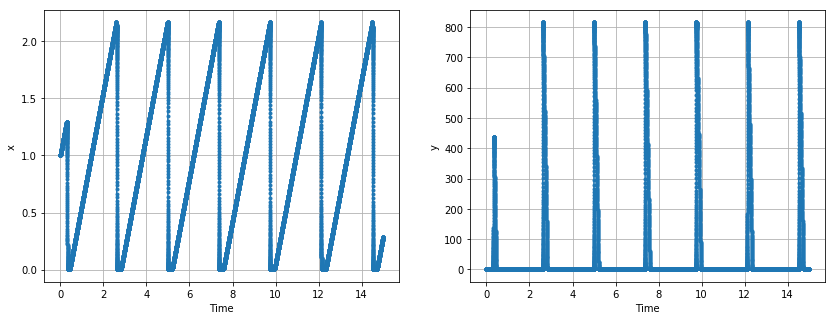

In [39]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(T, Y[:, 0], '.-')
plt.xlabel('Time')
plt.ylabel('x')
plt.grid()
plt.subplot(1,2,2); plt.plot(T, Y[:, 1], '.-')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(); plt.show()

In [40]:
a = 1e6 #1e6, 1e3
c = 0.7
b = 6.
def bongoff_van_der_pole(t, u, jac=False):
    y1, y2 = u
    if jac:
        return np.array([[-a * y1**2 + a, a], [-1., -b]])
    return np.array([a * (-(y1**3 / 3. - y1) + y2),
                    -y1 - b * y2 + c])
bongoff_van_der_pole_init = np.array([2, 0])
bongoff_van_der_pole_tmax = 5.

# Неявный метод Лобатто

In [41]:
T, Y, Y_ = adaptive_stepsize(glicole, glicole_init, glicole_tmax, imlobatto, 1e-3, 1e-4)


it =  250
|u1 - u2|: 
2.10939846457e-06
err =  2.8125312861e-06
fac =  7.08436419262
taunew =  0.000984973267581
curr t =  0.231453691149
it =  500
|u1 - u2|: 
0.000391427328628
err =  0.000521903104837
fac =  1.24204321437
taunew =  2.92773742661e-05
curr t =  0.324695026464
it =  750
|u1 - u2|: 
0.000384279319663
err =  0.000512372426217
fac =  1.24969706566
taunew =  1.44687293292e-05
curr t =  0.329377091569
it =  1000
|u1 - u2|: 
0.000386381726696
err =  0.000515175635595
fac =  1.24742629594
taunew =  1.48837996985e-05
curr t =  0.334168261305
it =  1250
|u1 - u2|: 
0.000380321090166
err =  0.000507094786888
fac =  1.25401756024
taunew =  1.89856580306e-05
curr t =  0.337990211104
it =  1500
|u1 - u2|: 
0.000258141015284
err =  0.000344188020379
fac =  1.42692588572
taunew =  0.000600801200289
curr t =  0.35448031294
it =  1750
|u1 - u2|: 
0.000385403448693
err =  0.000513871264925
fac =  1.24848086065
taunew =  8.73701359582e-05
curr t =  0.46124314689
it =  2000
|u1 - u2|: 
2.7

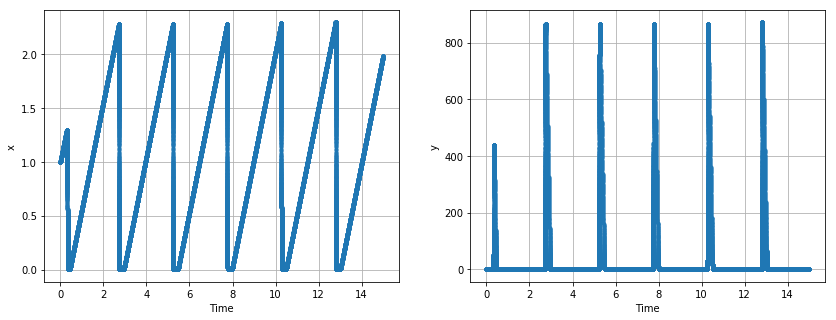

In [42]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(T, Y[:, 0], '.-')
plt.xlabel('Time')
plt.ylabel('x')
plt.grid()
plt.subplot(1,2,2); plt.plot(T, Y[:, 1], '.-')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(); plt.show()

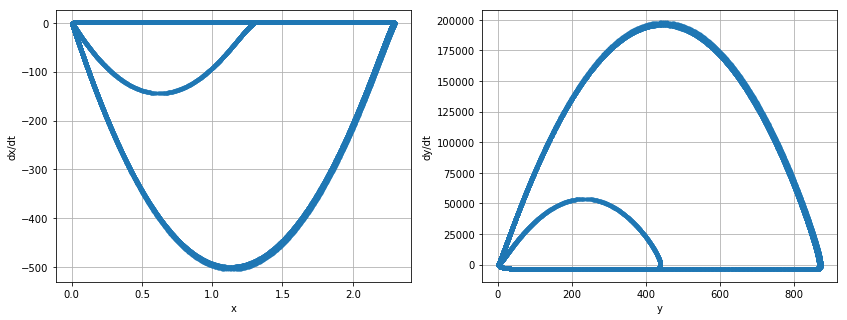

In [43]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(Y[:,0], Y_[:, 0], '.-')
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.grid(); 
plt.subplot(1,2,2); plt.plot(Y[:,1], Y_[:, 1], '.-')
plt.xlabel('y')
plt.ylabel('dy/dt')
plt.grid(); plt.show()

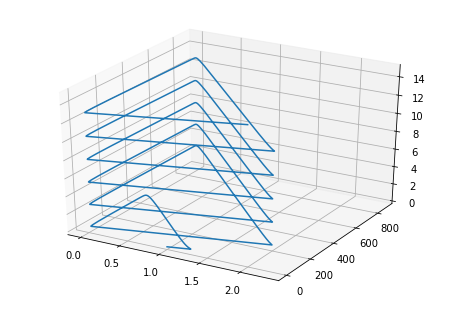

In [44]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

x = Y[:,0]
y = Y[:,1]
z = T

ax.plot(x, y, z, zdir='z', label='zs=0, zdir=z')

plt.show()

In [49]:
def chem(t, u):
    x, y = u
    return np.array([-0.5*x+30*y, -30*y])

chem_init = np.array([0, 1])
chem_tmax = 5

it =  250
|u1 - u2|: 
1.30506901892e-07
err =  2.61013803784e-07
fac =  61.8968092795
taunew =  0.000998657926881
curr t =  0.249665823793
it =  500
|u1 - u2|: 
4.93470338966e-08
err =  9.86940677932e-08
fac =  100.65943198
taunew =  0.000998657926881
curr t =  0.499330305513
it =  750
|u1 - u2|: 
4.36060363374e-08
err =  8.72120726747e-08
fac =  107.080821908
taunew =  0.000998657926881
curr t =  0.748994787234
it =  1000
|u1 - u2|: 
3.84874739856e-08
err =  7.69749479712e-08
fac =  113.97911958
taunew =  0.000998657926881
curr t =  0.998659268954
it =  1250
|u1 - u2|: 
3.39697160401e-08
err =  6.79394320802e-08
fac =  121.321855529
taunew =  0.000998657926881
curr t =  1.24832375067
it =  1500
|u1 - u2|: 
2.99822638938e-08
err =  5.99645277877e-08
fac =  129.137623827
taunew =  0.000998657926881
curr t =  1.49798823239
it =  1750
|u1 - u2|: 
2.64628691737e-08
err =  5.29257383475e-08
fac =  137.456897482
taunew =  0.000998657926881
curr t =  1.74765271411
it =  2000
|u1 - u2|: 
2.335

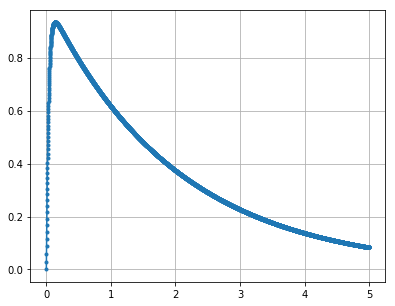

In [71]:
T, Y, Y_ = adaptive_stepsize(chem, chem_init, chem_tmax, euler, tol=1e-3, tau=1e-3)
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(T, Y[:, 0], '.-'); 
plt.grid(); plt.show()